### Import packages

`scipy.sparse` will be used for sparse matrix construction

In [24]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
%matplotlib inline

### Set up the grid

`V` is a list of vertices.  `E` is a list of elements (segments).

In [25]:
nx = 4 # number of poitns

V = np.linspace(0,1,nx) # list of vertices
E = np.zeros((nx-1,2), dtype=int) # list of elements
E[:,0] = np.arange(0,nx-1)
E[:,1] = np.arange(1,nx)
h = V[1] - V[0] # mesh spacing

### The problem

$$
- u'' = f(x)
$$
$$
u(0) = u(1) = 0
$$

Steps for each element:

1. add the element stiffness matrix to the global entries
1. add the element rhs values to the global entries
1. convert entries to sparse matrices

In [26]:
Ak = (1/h) * np.array([1, -1, -1, 1])
Fk = (h/2) * np.array([1, 1])
rows = []
cols = []
vals = []
frows = []
fcols = []   # all zero
fvals = []

for tau in E:
    rows += [tau[0], tau[0], tau[1], tau[1]]
    cols += [tau[0], tau[1], tau[0], tau[1]]
    vals += Ak.tolist()
    
    frows += [tau[0], tau[1]]
    fcols += [0, 0]
    fvals += Fk.tolist()
    
A = sparse.coo_matrix((vals, (rows, cols))).tocsr()
F = sparse.coo_matrix((fvals, (frows, fcols))).tocsr().toarray()

Think about the line `[tau[0], tau[0], tau[1], tau[1]]`.  For the first element this would be `[0, 0, 1, 1]` while `[tau[0], tau[1], tau[0], tau[1]]` would be `[0, 1, 0, 1]`

Also notice that `rows` and `cols` have some duplicate entries:

In [27]:
print(rows)
print(cols)

[0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3]
[0, 1, 0, 1, 1, 2, 1, 2, 2, 3, 2, 3]


When we run the sparse matrix assembly:

In [28]:
A = sparse.coo_matrix((vals, (rows, cols)))
print(A.row)
print(A.col)

[0 0 1 1 1 1 2 2 2 2 3 3]
[0 1 0 1 1 2 1 2 2 3 2 3]


Notice the values are still duplicated.  When converted to CSR (and then back to COO), then the duplicate entries are summed:

In [29]:
A = sparse.coo_matrix((vals, (rows, cols))).tocsr().tocoo()
print(A.row)
print(A.col)

[0 0 1 1 1 2 2 2 3 3]
[0 1 0 1 2 1 2 3 2 3]


This trick is used for the right-hand side even though the right-hand side `F` is a vector (i.e. a matrix with one column):

In [30]:
F = sparse.coo_matrix((fvals, (frows, fcols)))
print(F.row)
print(F.data)
F = sparse.coo_matrix((fvals, (frows, fcols))).tocsr().toarray()
print(F)

[0 1 1 2 2 3]
[ 0.16666667  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667]
[[ 0.16666667]
 [ 0.33333333]
 [ 0.33333333]
 [ 0.16666667]]


### Check it

Here we want to make sure that the three element case makes sense.  Since we constructed by hand:
$$
A = \begin{bmatrix}
1 & -1 & 0 & 0\\
0 &  2 &-1 & 0\\
1 & -1 & 2 &-1\\
0 &  0 &-1 & 1\\
\end{bmatrix}
$$

In [31]:
print(A.toarray()*h)
print(F*2/h)

[[ 1. -1.  0.  0.]
 [-1.  2. -1.  0.]
 [ 0. -1.  2. -1.]
 [ 0.  0. -1.  1.]]
[[ 1.]
 [ 2.]
 [ 2.]
 [ 1.]]


but this is singular!

### Now add boundary conditions

In [32]:
nx = 100

V = np.linspace(0,1,nx)
E = np.zeros((nx-1,2), dtype=int)
E[:,0] = np.arange(0,nx-1)
E[:,1] = np.arange(1,nx)
h = V[1] - V[0]

Let's also add a more complex right-hand side:

In [33]:
def f(x):
    return np.exp(-(x-0.5)**2 / 0.001)

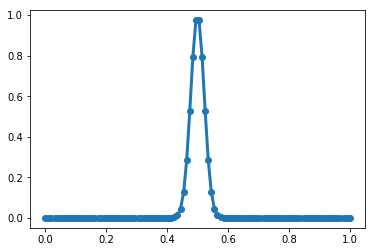

In [34]:
plt.plot(V, f(V), 'o-', lw=3)

Here we're going to make sure that element `tau` doesn't have a boundary basis.  If does, then we'll ignore it.  So we'll loop over every combination of basis functions in `tau`.  Here we convert `Ak` to an array to make indexing easier.

In [35]:
Ak = (1/h) * np.array([[1, -1], [-1, 1]])
Fk = (h/2) * np.array([1, 1])
rows = []
cols = []
vals = []
frows = []
fcols = []
fvals = []

for tau in E:
    for k1 in range(2):
        for k2 in range(2):
            # tau[k1] will be the left basis function
            # tau[k2] will be the right basis function
            if tau[k1]!=0 and tau[k2]!=0 and tau[k1]!=(nx-1) and tau[k2]!=(nx-1):
                rows += [tau[k1]]
                cols += [tau[k2]]
                vals += [Ak[k1,k2]]           
        if tau[k1]!=0 and tau[k1]!=(nx-1):
            frows += [tau[k1]]
            fcols += [0]
            fvals += [(h/2) * f(V[tau[k1]])]

rows = np.array(rows)
cols = np.array(cols)
frows = np.array(frows)
fcols = np.array(fcols)
A = sparse.coo_matrix((vals, (rows-1, cols-1))).tocsr()
F = sparse.coo_matrix((fvals, (frows-1, fcols))).tocsr().toarray()

One thing to notice is that we need to *shift* the indices since zero is not a degree of freedom (due to the boundary condition).  Thus `rows-1` is used instead of `rows`.

In [36]:
u = sla.spsolve(A, F)

Here it's important to note that `u` is defined at the degrees of freedom.  Since Dirichlet conditions are imposed on the left and on the right, this removed two dofs from the problem:

In [37]:
print(len(V))
print(len(u))

100
98


So we push a zero onto each end of `u`:

In [38]:
u = np.hstack(([0], u, [0]))

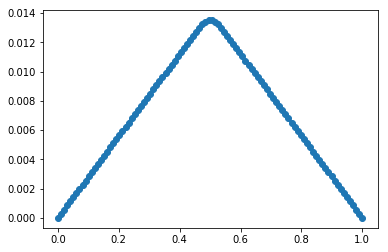

In [39]:
plt.plot(V, u, 'o-', lw=3)